In [214]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

import os
from typing import Dict
from os import PathLike
from pathlib import Path

from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
import datetime

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='yellow'
odor_list_color = [color1, color2, color3, color4]
color_dict_label = {'NULL': color1, 'ODOR_A': color2, 'ODOR_B': color3, 'ODOR_C': color4}
pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = 'Z:/scratch/vr-foraging/data/'
data_path = r'C:\git\Aind.Behavior.VrForaging.Analysis\data'
foraging_figures = r'C:\git\Aind.Behavior.VrForaging.Analysis\results\\novelty_experiment'

from scipy.optimize import curve_fit


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
mouse_list = ['717716','717717', '745306', '745305', '745300', '745301']

In [130]:
summary_df = pd.DataFrame()
all_epochs = pd.DataFrame()
within_session_n = 0
experiment = 0
for mouse in mouse_list:
    print(mouse)
    session_n = 0
    directory = os.path.join(base_path, mouse)
    files = os.listdir(os.path.join(base_path, mouse))
    sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=False)
    
    with PdfPages(os.path.join(foraging_figures, f'{mouse}_velocity_traces_novelty.pdf')) as pdf:
        for file_name in sorted_files:
            session_path = os.path.join(base_path, mouse, file_name)
            session = file_name[7:15]
            print(session)

            session_path = Path(session_path)

            try:
                data = parse.load_session_data(session_path)
            except:
                print('Error loading session')
                continue
            
            # Parse data
            reward_sites, active_site, config = parse.parse_dataframe(data)
            
            if reward_sites.empty:           
                continue
            
            reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
            active_site = AddExtraColumns(reward_sites, active_site, run_on_init=True).add_time_previous_intersite_interpatch()
            encoder_data = parse.ContinuousData(data).encoder_data

            trial_summary = plotting.trial_collection(reward_sites[['has_choice', 'visit_number', 'odor_label', 'odor_sites']], encoder_data, mouse, session, window=(-1,3))
            plotting.velocity_traces_odor_entry(trial_summary, 
                                                max_range=max(trial_summary.speed.values), 
                                                color_dict_label=color_dict_label, 
                                                mean=True, 
                                                save=pdf, 
                                                mouse=mouse, 
                                                session=session)

            session_n += 1

            active_site['next_intersite'] = active_site.index.to_series().shift(-1)
            active_site['time_in_site'] = active_site.next_intersite - active_site.index
            active_site['mouse'] = mouse
            active_site['session'] = session
            active_site['session_n'] = session_n
            active_site['session_type'] = data['config'].streams.tasklogic_input.data['stage_name']
            active_site['distance_in_session'] = active_site['length'].shift(1).cumsum()
            active_site['distance_in_session'] = active_site['distance_in_session']/100
            active_site['time_in_session'] = active_site['time_in_site'].shift(1).cumsum()

            active_site = active_site[['label', 'start_position', 'length', 'active_patch','odor_label','odor_sites','total_sites', 'previous_interpatch',
                'previous_intersite', 'same_patch', 'time_in_site', 'mouse', 'session', 'session_n', 'session_type','time_in_session', 'distance_in_session']]
            
            summary_df = pd.concat([summary_df, active_site])

print('Saving')


717716
20240710
20240711
20240712
20240712
Different timing than values,  1000 1001
20240713
Different timing than values,  1000 1001
20240715
20240716
20240717
Different timing than values,  1000 1001
20240718
Different timing than values,  1000 1001
Different timing than values,  1000 1001
Different timing than values,  1000 1001
Different timing than values,  1000 1001
20240719
Different timing than values,  1000 1001
Different timing than values,  1000 1001
20240730
Different timing than values,  1000 1001
20240712
Error loading session
20240731
20240801
20240802
717717
20240723
Different timing than values,  1000 1001
Different timing than values,  1000 1001
Different timing than values,  1000 1001
Different timing than values,  1000 1001
Different timing than values,  1000 1001
20240724
Different timing than values,  1000 1001
20240725
Different timing than values,  1000 1001
Different timing than values,  1000 1001
20240725
Different timing than values,  1000 1001
Different timi

In [193]:
summary_df['distance_in_session'] = summary_df['distance_in_session']/100


In [ ]:
def trial_collection(
    reward_sites: pd.DataFrame,
    continuous_data: pd.DataFrame,
    mouse: str,
    session: str,
    aligned: str = 'index',
    cropped_to_length: bool = False,
    window: list = [-0.5, 2],
    taken_col: str = "filtered_velocity",
):
    """
    Crop the snippets of speed traces that are aligned to different epochs

    Parameters
    ----------
    reward_sites : pd.DataFrame
        DataFrame containing the reward sites information (odor sites)
    continuous_data : pd.DataFrame
        DataFrame containing the continuous data (encoder, sniffing, etc)
    mouse : str
        Mouse name
    session : str
        Session name
    aligned : str
        Column name to align the snippets
    window : tuple
        Time window to crop the snippets
    taken_col: string
        name of the column that you want to segment the data from. Default is 'filtered_velocity'

    Returns
    -------
    trial_summary : pd.DataFrame
        DataFrame containing the snippets of speed traces aligned to different epochs

    """
    trial_summary = pd.DataFrame()
    samples_per_second = np.around(np.mean(continuous_data.index.diff().dropna()), 3)
    
    # Iterate through reward sites and align the continuous data to whatever value was chosen. If aligned is used, it will align to any of the columns with time values.
    # If align is empty, it will align to the index, which in the case of the standard reward sites is the start of the odor site.
    for start_reward, row in reward_sites.iloc[:-1].iterrows():
        if cropped_to_length:
            window[0] = row['previous_intersite']
            window[1] = row['next_intersite']
            
        trial_average = pd.DataFrame()
        if aligned != 'index':
            
            trial = continuous_data[(continuous_data.index >= row[aligned] + window[0]) & (continuous_data.index < row[aligned] + window[1])][taken_col]
            trial.index -= row[aligned]
        else:
            trial = continuous_data.loc[
                start_reward + window[0] : start_reward + window[1], taken_col
            ]
            trial.index -= start_reward

        # Assuming trial.values, window, and samples_per_second are defined
        # Calculate the maximum number of intervals that can fit within the available data points
        max_intervals = len(trial.values) * samples_per_second

        # Calculate the actual stop value based on the maximum possible intervals
        actual_stop = min(window[1], window[0] + max_intervals)

        # Generate the time range with the adjusted stop value
        times = np.arange(window[0], actual_stop, samples_per_second)
        if len(times) != len(trial.values):
            # print('Different timing than values, ', len(times), len(trial.values))
            trial = trial.values[:len(times)]
        else:
            trial = trial.values
            
        trial_average["times"] = times

        if len(trial) == len(trial_average["times"]):
            if "filtered_velocity" == taken_col:
                trial_average["speed"] = trial
            else:
                trial_average[taken_col] = trial
        else:
            continue
        # Rewrites all the columns in the reward_sites to be able to segment the chosen traces in different values
        for column in reward_sites.columns:
            trial_average[column] = np.repeat(row[column], len(trial))

        trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)

    trial_summary["mouse"] = mouse
    trial_summary["session"] = session
    return trial_summary


In [220]:
summary_df.loc[(summary_df['mouse'] == '717716') & (summary_df['session'].astype(int)> 20240729),'experimental_round'] = 2
summary_df.loc[(summary_df['mouse'] == '745305') & (summary_df['session'].astype(int)> 20240729),'experimental_round'] = 2

# Find the biggest session_n for session type session_0 for each mouse
summary_df['max_session_n_session_0'] = summary_df[summary_df['session_type'] == 'session_0'].groupby('mouse')['session_n'].transform('max')

summary_df.to_csv(os.path.join(data_path, 'novelty_df.csv'), index=False)

### Explore plots

In [110]:
summary_df = pd.read_csv(os.path.join(data_path, 'novelty_df.csv'))

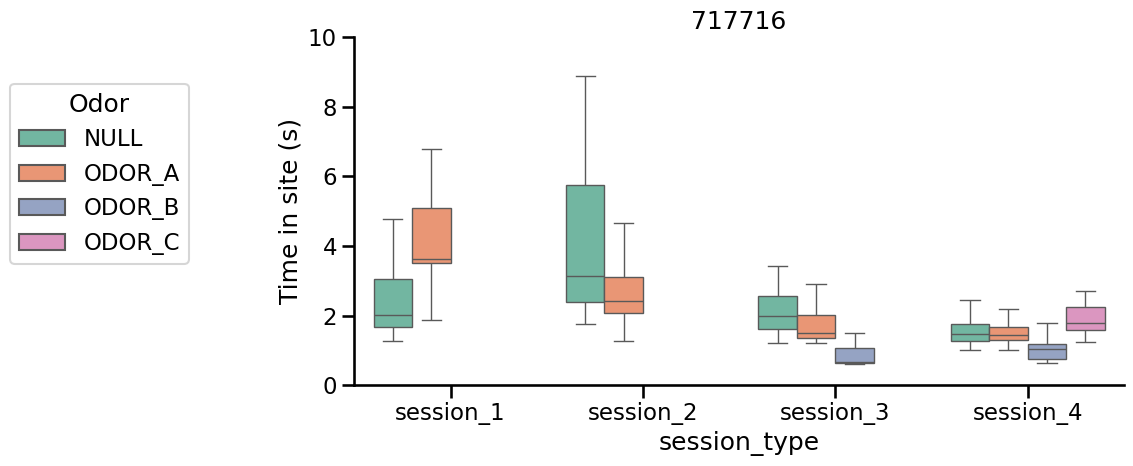

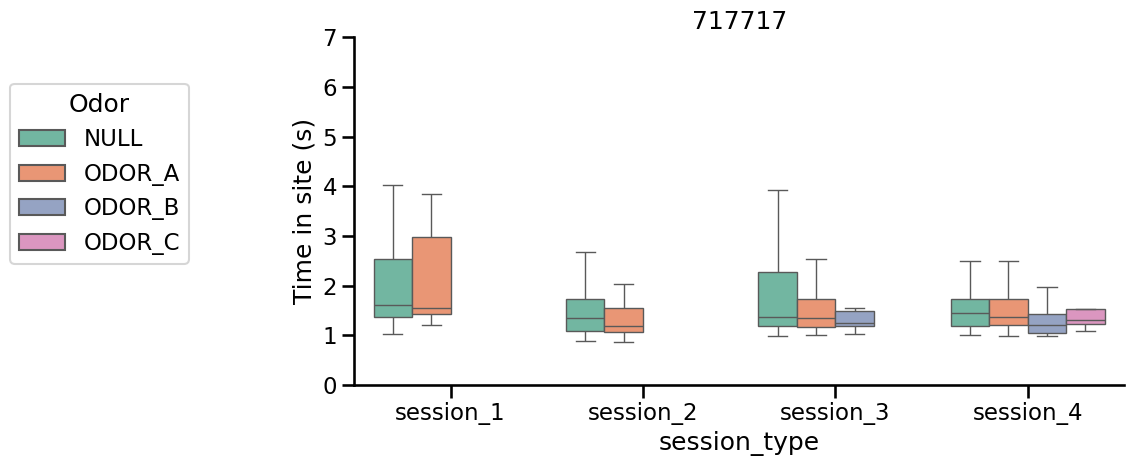

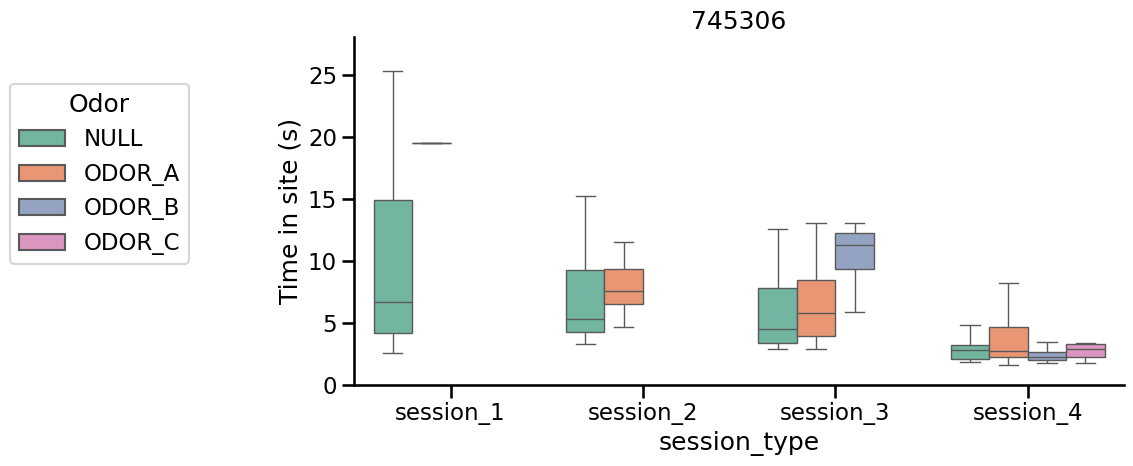

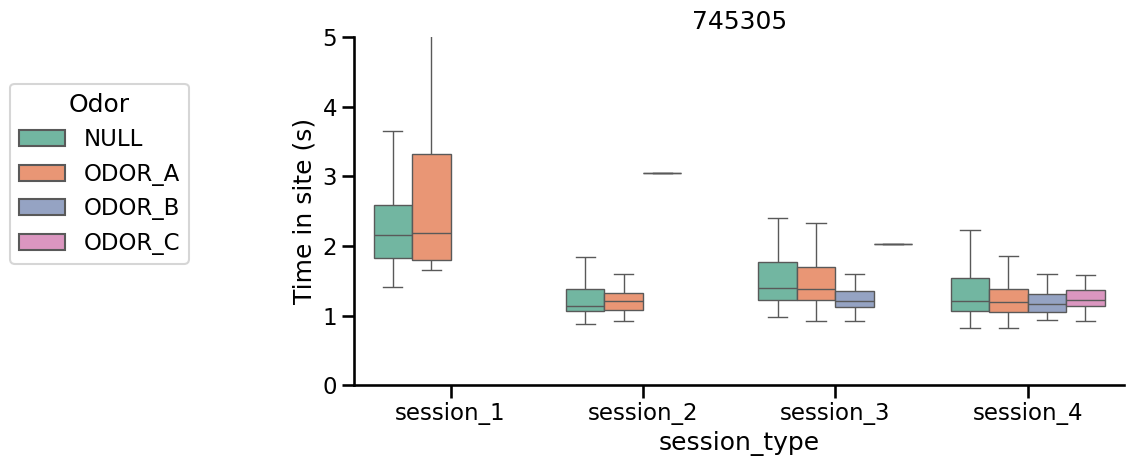

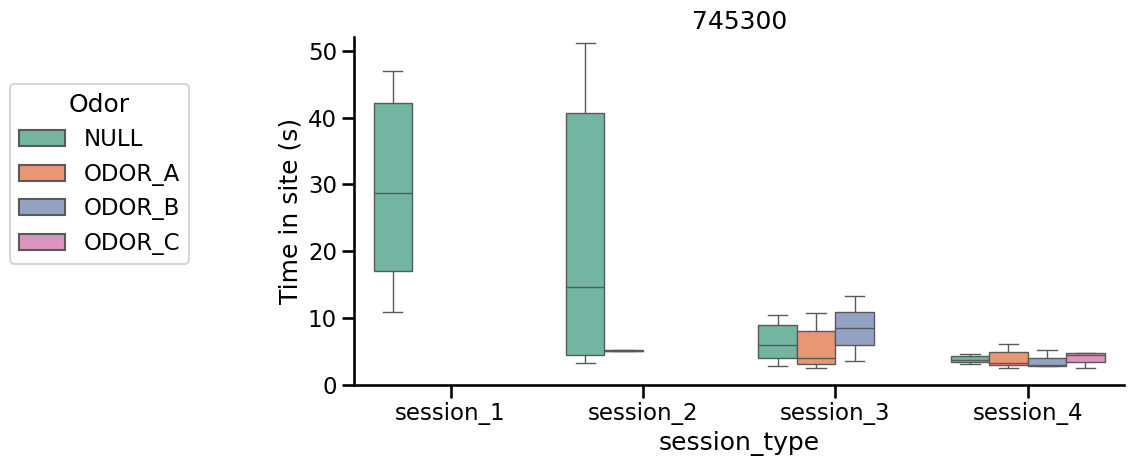

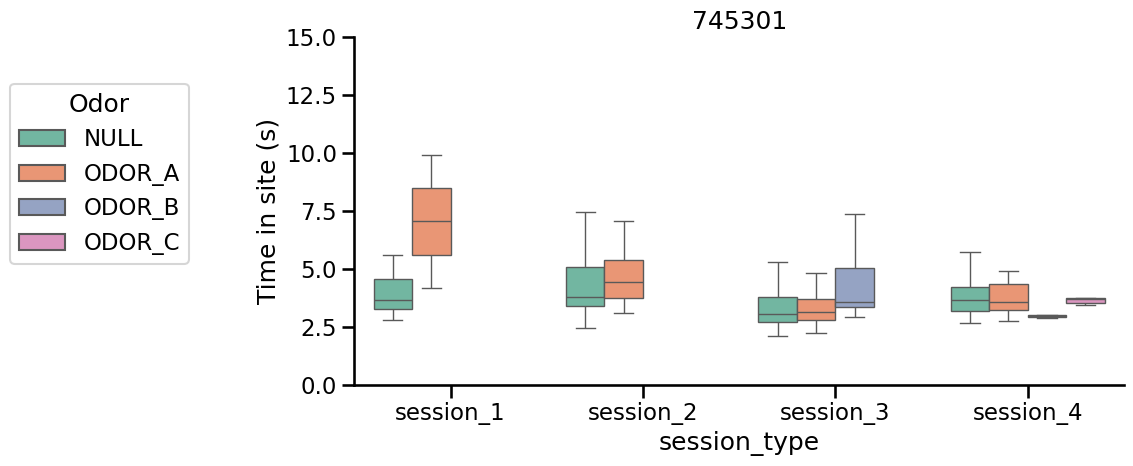

In [191]:
for mouse in summary_df.mouse.unique():
    fig = plt.figure(figsize=(12, 5))
    sns.boxplot(x='session_type', y='time_in_site', data=summary_df[(summary_df.mouse==mouse)&(summary_df.session_type != 'session_0')&(summary_df.experimental_round == 1)], 
                hue='odor_label', palette='Set2', dodge=True, hue_order= ['NULL', 'ODOR_A', 'ODOR_B', 'ODOR_C'], fliersize=0)

    plt.ylabel('Time in site (s)')
    plt.title(f'{mouse}')
    plt.legend(bbox_to_anchor = (-0.2, 0.9), title='Odor', loc='upper right')
    plt.ylim(0, int(summary_df[summary_df.mouse==mouse].time_in_site.quantile(0.85)))
    plt.tight_layout()
    sns.despine()
    plt.show()

##### Distance in session for the time in session across several mice

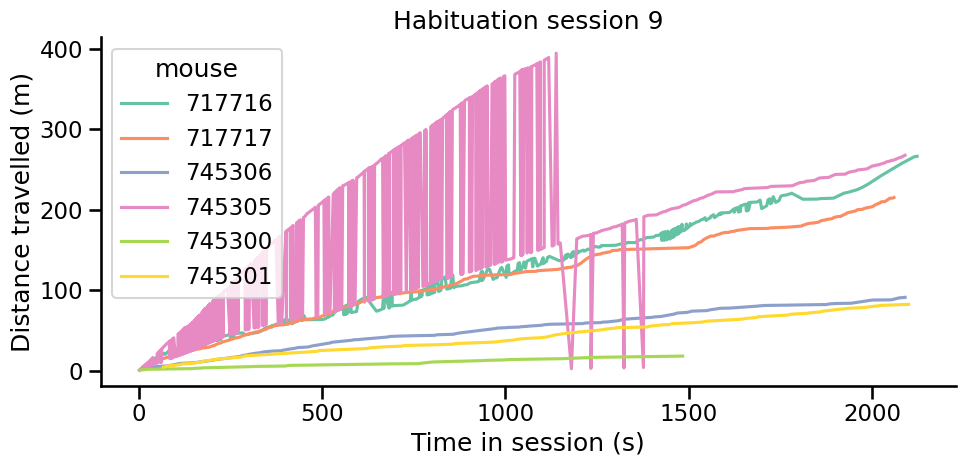

In [222]:
fig = plt.figure(figsize=(10, 5))
sns.lineplot(x='time_in_session', y='distance_in_session', data=summary_df[(summary_df.session_type == 'session_1')], hue='mouse', palette='Set2', ci=None)
plt.title(f'Habituation session {session}')
plt.xlabel('Time in session (s)')
plt.ylabel('Distance travelled (m)')
plt.tight_layout()
sns.despine()
plt.show()
fig.savefig(os.path.join(foraging_figures, f'session_1_distance_travelled.svg'))

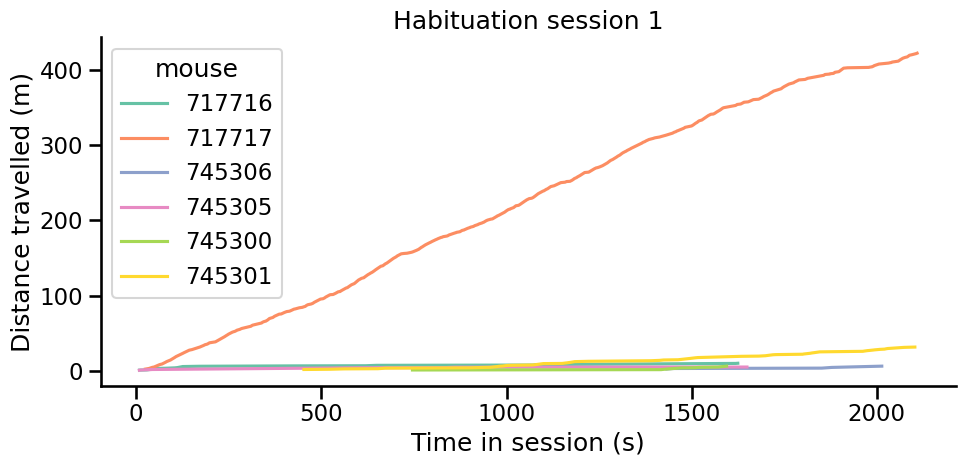

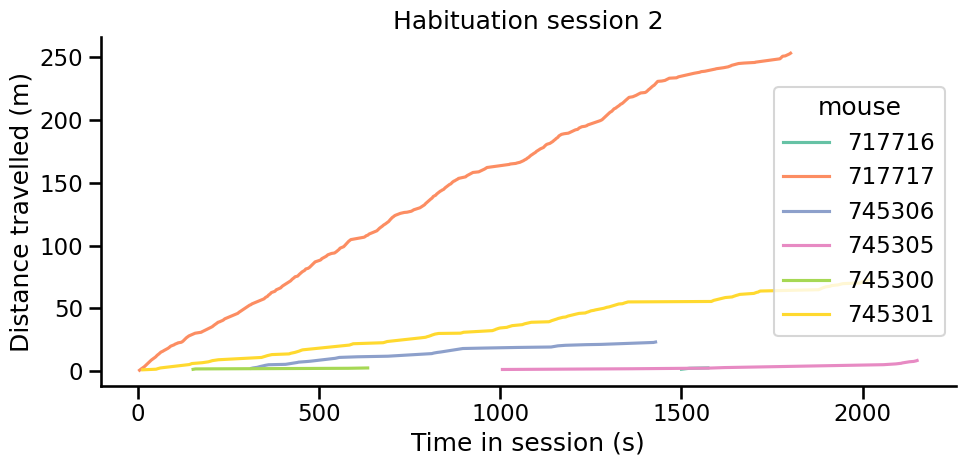

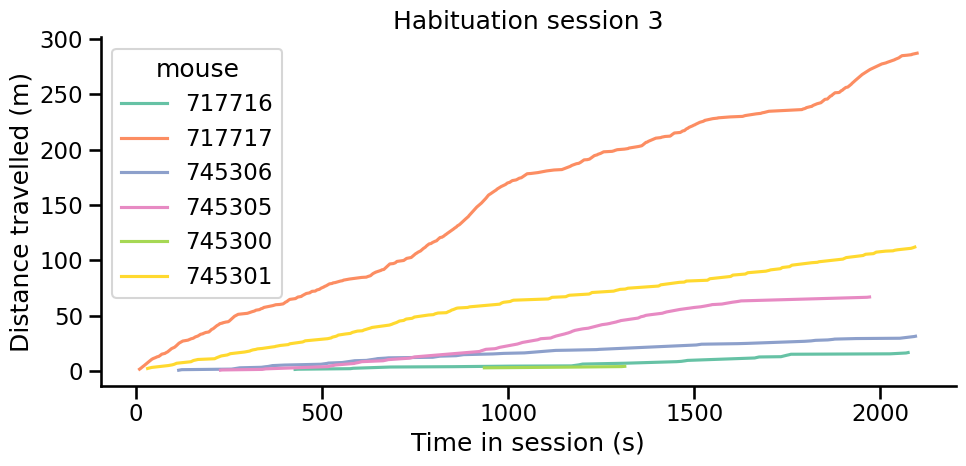

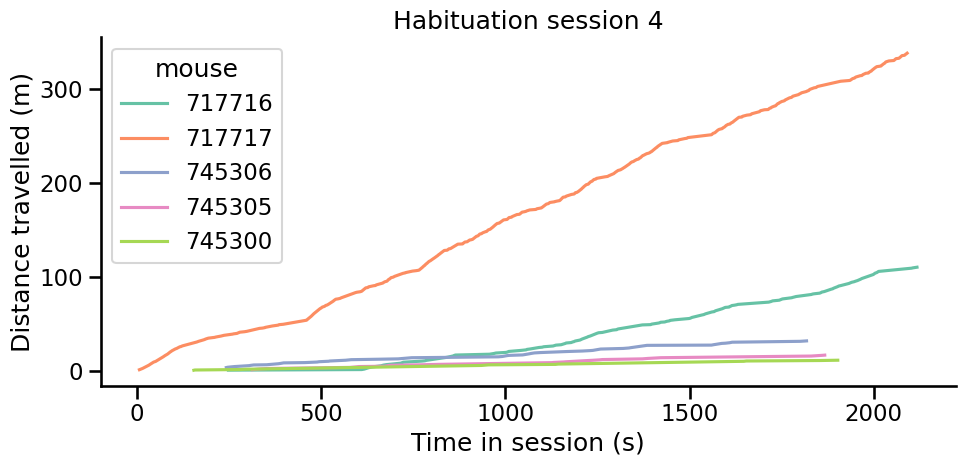

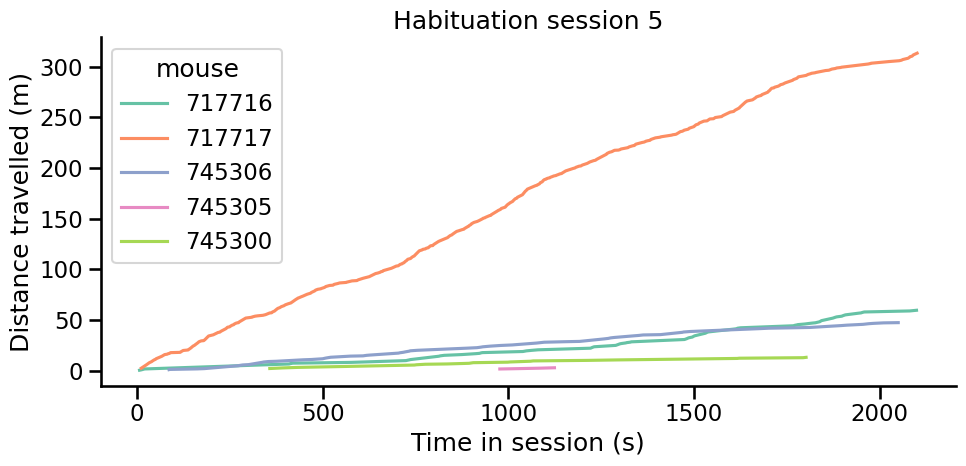

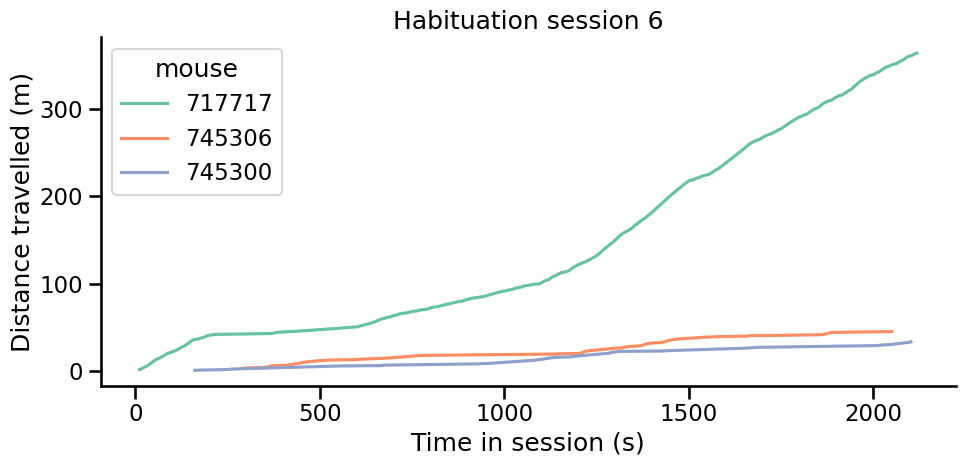

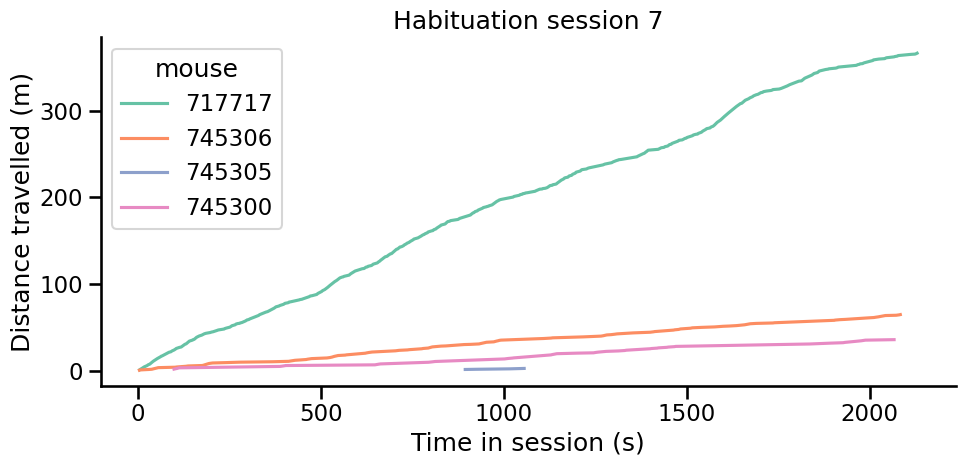

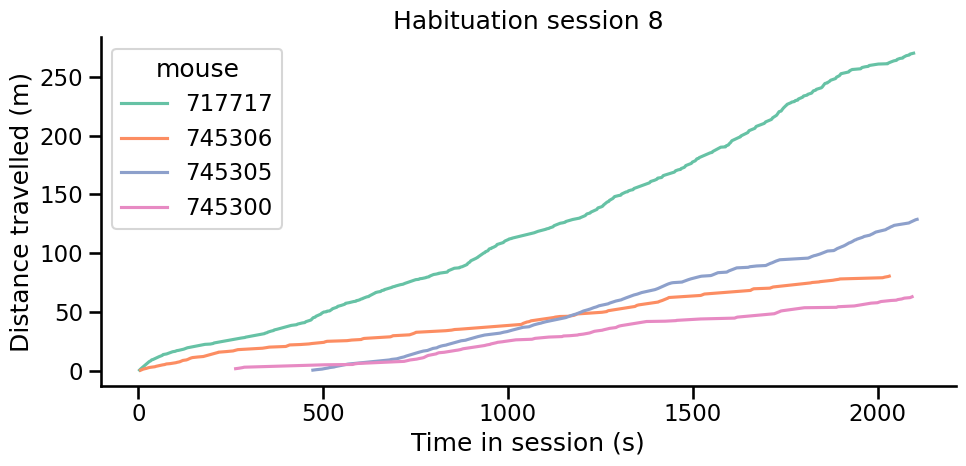

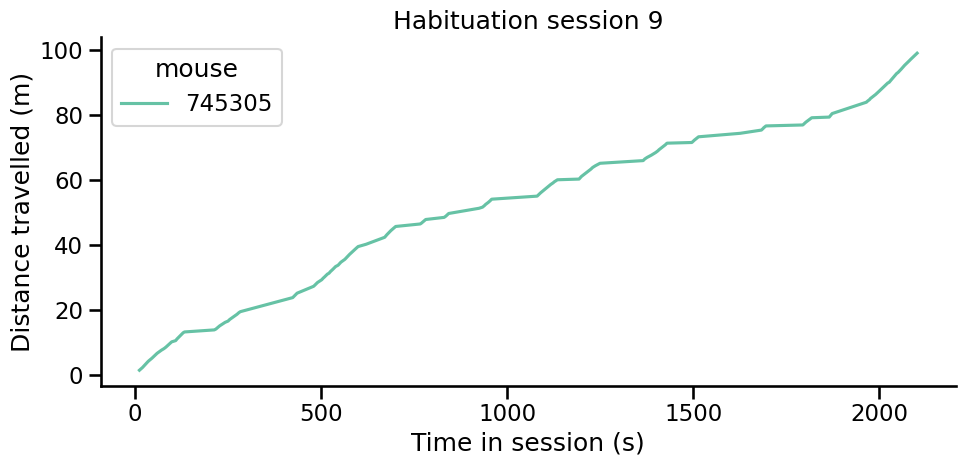

In [221]:
for session in summary_df[(summary_df.session_type == 'session_0')].session_n.unique():
    fig = plt.figure(figsize=(10, 5))
    sns.lineplot(x='time_in_session', y='distance_in_session', data=summary_df[(summary_df.session_n==session)&(summary_df.session_type == 'session_0')], hue='mouse', palette='Set2', ci=None)
    plt.title(f'Habituation session {session}')
    plt.xlabel('Time in session (s)')
    plt.ylabel('Distance travelled (m)')
    plt.tight_layout()
    sns.despine()
    plt.show()
    fig.savefig(os.path.join(foraging_figures, f'{session}_distance_travelled.svg'))

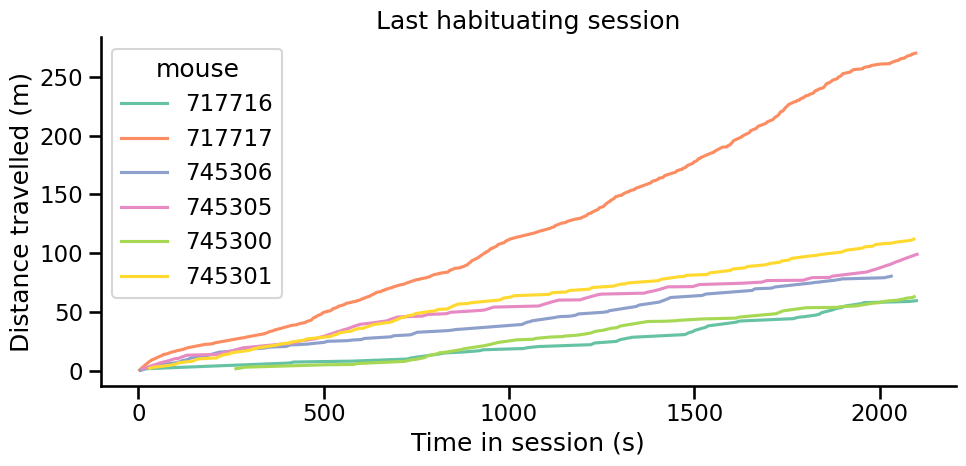

In [216]:
summary_df['last_session'] = np.where(summary_df['session_n'] == summary_df['max_session_n_session_0'], 1, 0)

fig = plt.figure(figsize=(10, 5))
sns.lineplot(x='time_in_session', y='distance_in_session', data=summary_df[(summary_df.last_session==1)], hue='mouse', palette='Set2', ci=None)
plt.title(f'{session}')
plt.xlabel('Time in session (s)')
plt.ylabel('Distance travelled (m)')
plt.title('Last habituating session')
plt.tight_layout()
sns.despine()
plt.show()
fig.savefig(os.path.join(foraging_figures, 'last_habituating_session.svg'), dpi=300)

##### Distance in session for the time in session across several sessions

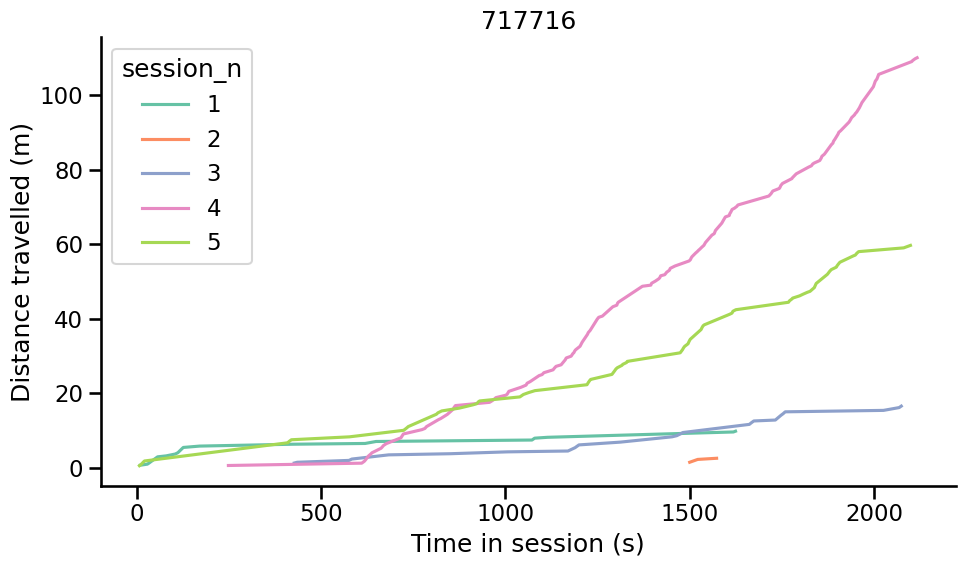

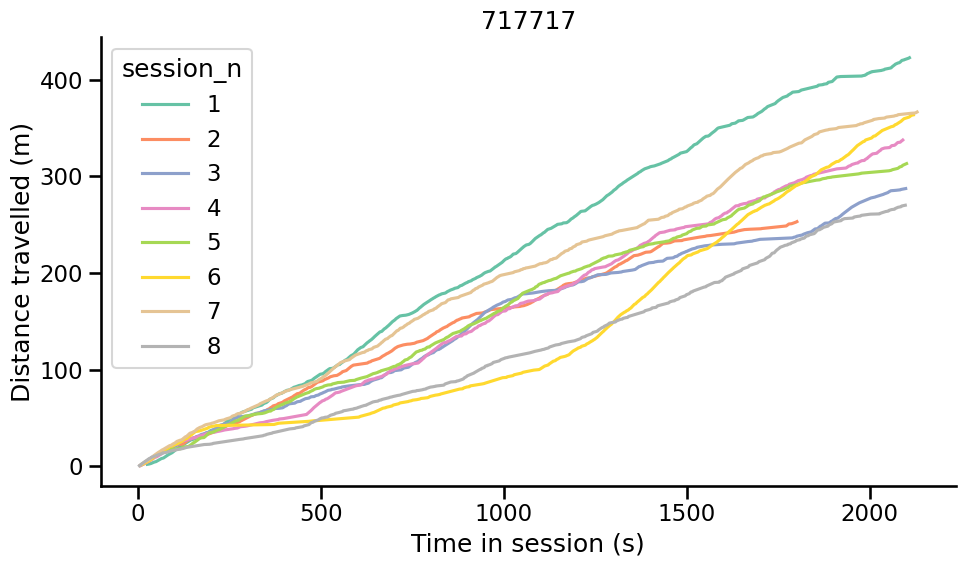

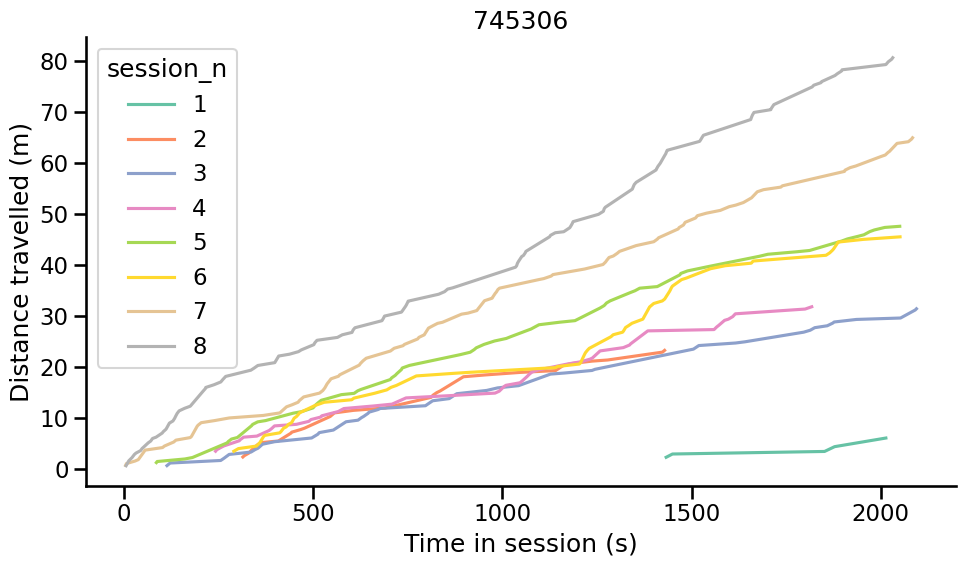

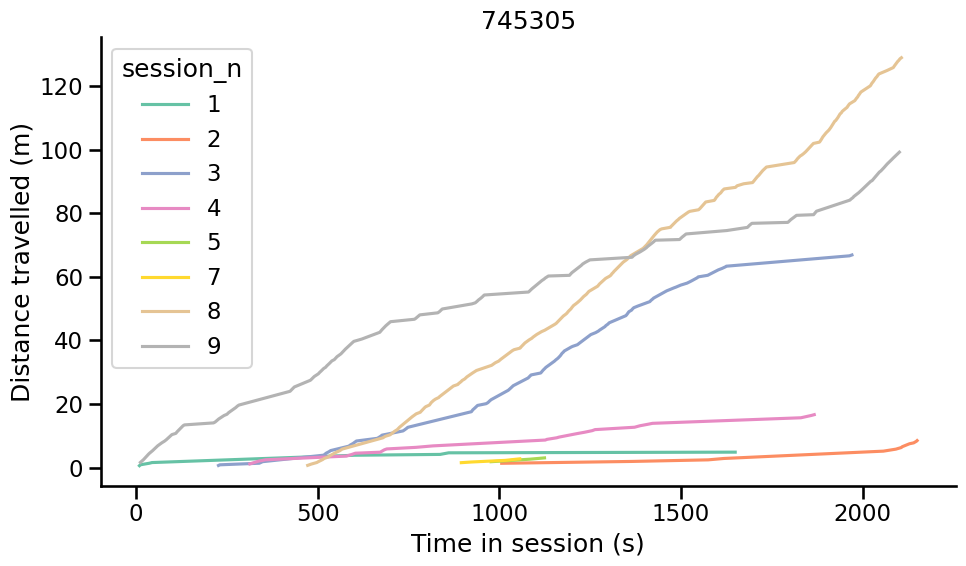

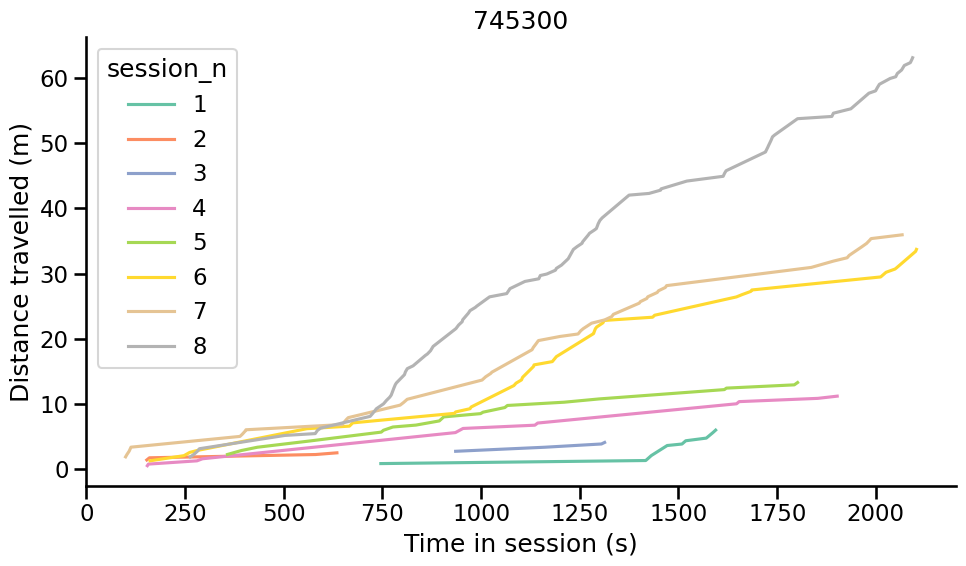

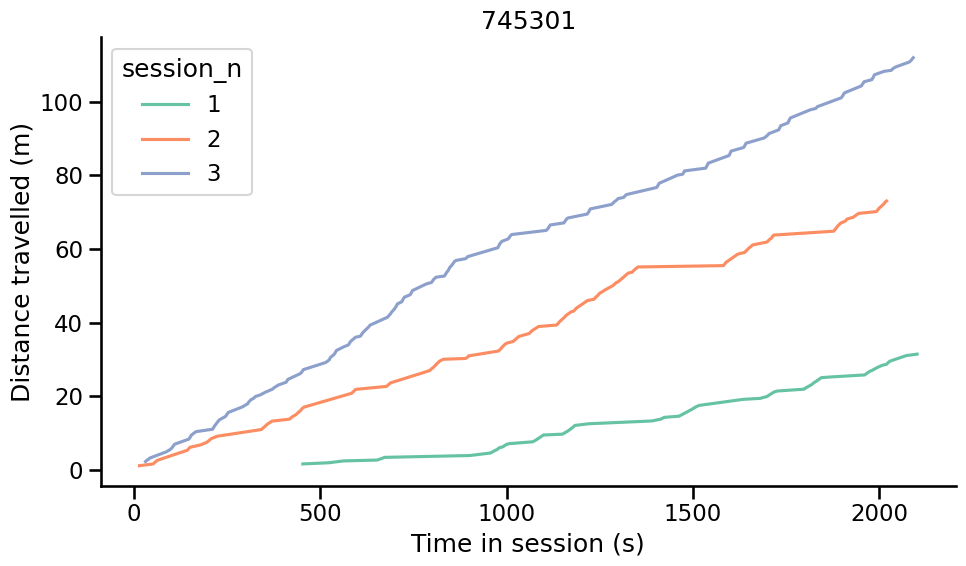

In [219]:
for mouse in summary_df.mouse.unique():
    fig = plt.figure(figsize=(10, 6))
    sns.lineplot(x='time_in_session', y='distance_in_session', hue='session_n', data=summary_df[(summary_df.mouse==mouse)&(summary_df.session_type == 'session_0')],  palette='Set2', ci=None)
    plt.title(f'{mouse}')
    plt.xlabel('Time in session (s)')
    plt.ylabel('Distance travelled (m)')
    plt.tight_layout()
    sns.despine()
    plt.show()
    fig.savefig(os.path.join(foraging_figures, f'across_sessions_mouse_{mouse}.svg'), dpi=300)